In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
# plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from Backtest import *
np.random.seed(56)

In [7]:
# Import the data
stock_symbol = 'AAPL'
df = yf.download(stock_symbol, end="2021-01-01")[["Adj Close"]].pct_change(1)
df.columns = ["returns"]

# Features engeeniring
df["returns t-1"] = df[["returns"]].shift(1)

# Mean of returns
df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)

# Volatility of returns
df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)

# Drop missing values
df = df.dropna()

# Percentage train set
split = int(0.80*len(df))

# Train set creation
X_train = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[:split]

y_train_reg = df[["returns"]].iloc[:split]

y_train_cla = np.round(df[["returns"]].iloc[:split]+0.5)


# Test set creation
X_test = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[split:]

y_test_reg = df[["returns"]].iloc[split:]
y_test_cla = np.round(df[["returns"]].iloc[split:]+0.5)


# NORMALIZATION 
# Import the class
from sklearn.preprocessing import StandardScaler

# Initialize the class
sc = StandardScaler()

# Standardize the data
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

[*********************100%%**********************]  1 of 1 completed


In [8]:
np.random.seed(15)
# LIBAIRIES
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

nb_hidden_layer = 1


# INTIALIZATION SEQUENTIAL MODEL
classifier = Sequential()

# AJOUT COUCHE DENSE ET DROPOUT
for _ in range(nb_hidden_layer):
    classifier.add(Dense(75, input_shape = (X_train.shape[1],), activation="relu"))


# AJOUT COUCHE DENSE
classifier.add(Dense(1, activation="sigmoid"))

# COMPILATION DU MODÈLE
classifier.compile(loss="binary_crossentropy", optimizer="adam")

# TRAINING
classifier.fit(X_train_scaled, y_train_cla, epochs=15, batch_size=150, verbose=1)
classifier.save(f'{stock_symbol}.h5')

Epoch 1/15
54/54 [==============================] - 1s 5ms/step - loss: 0.7034
Epoch 2/15
54/54 [==============================] - 0s 4ms/step - loss: 0.6932
Epoch 3/15
54/54 [==============================] - 0s 4ms/step - loss: 0.6923
Epoch 4/15
54/54 [==============================] - 0s 4ms/step - loss: 0.6919
Epoch 5/15
54/54 [==============================] - 0s 4ms/step - loss: 0.6916
Epoch 6/15
54/54 [==============================] - 0s 4ms/step - loss: 0.6914
Epoch 7/15
54/54 [==============================] - 0s 4ms/step - loss: 0.6913
Epoch 8/15
54/54 [==============================] - 0s 4ms/step - loss: 0.6909
Epoch 9/15
54/54 [==============================] - 0s 4ms/step - loss: 0.6906
Epoch 10/15
54/54 [==============================] - 0s 4ms/step - loss: 0.6906
Epoch 11/15
54/54 [==============================] - 0s 5ms/step - loss: 0.6904
Epoch 12/15
54/54 [==============================] - 0s 8ms/step - loss: 0.6903
Epoch 13/15
54/54 [==============================

314/314 [==============================] - 1s 3ms/step
[*********************100%%**********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.23 	 Alpha: 17.49 %	     Sharpe: 0.594 	 Sortino: 0.053
  -----------------------------------------------------------------------------
    VaR: 5.34 %	 cVaR: 6.33 % 	     VaR/cVaR: 1.186 	 drawdown: 81.8 %
  -----------------------------------------------------------------------------


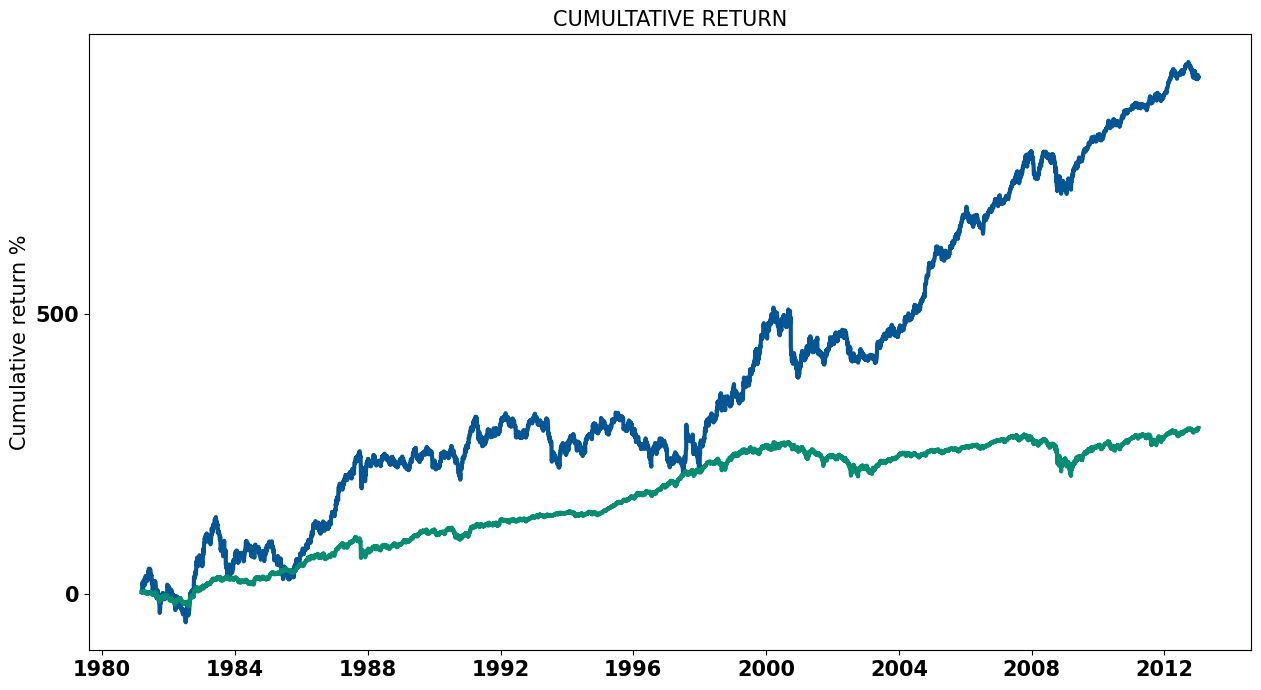

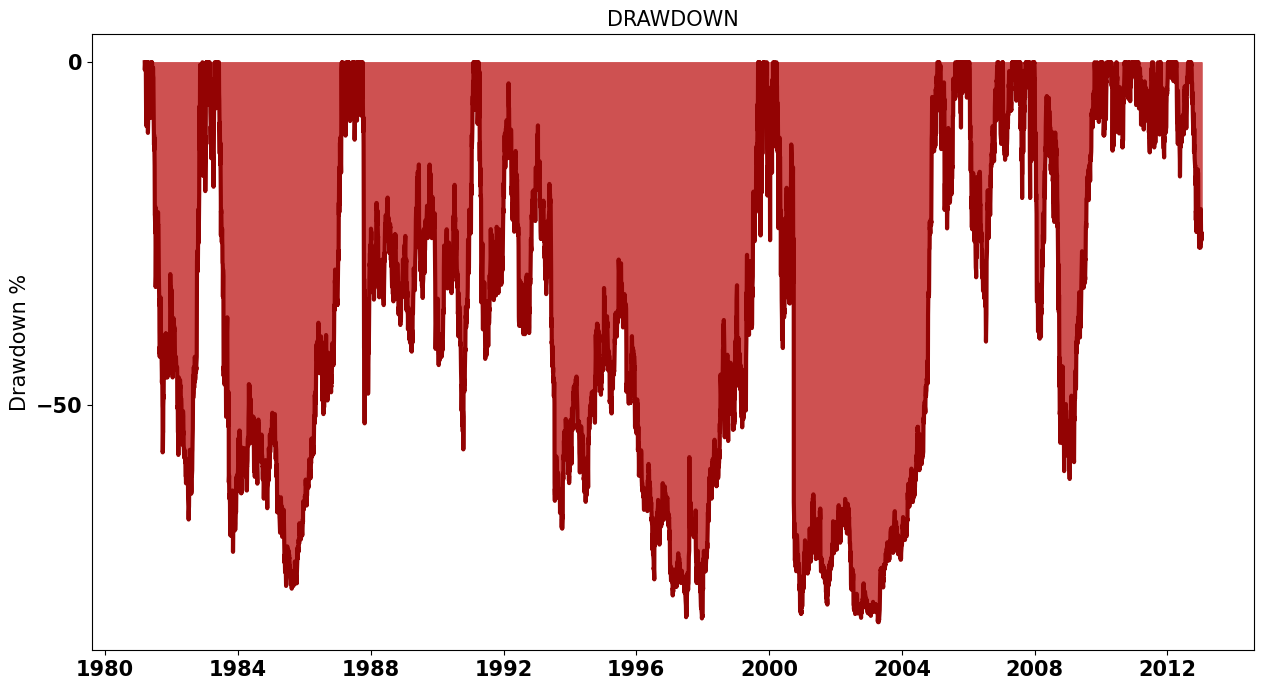

In [9]:
df["prediction"] = classifier.predict(np.concatenate((X_train,X_test),
                                    axis=0))
df["prediction"] = np.where(df["prediction"] == 0, -1,1)
# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[:split])

In [12]:
from tensorflow.keras.models import load_model

df = yf.download(stock_symbol)[["Adj Close"]].pct_change(1)
df.columns = ["returns"]

# Features engineering (similar to the training process)
df["returns t-1"] = df[["returns"]].shift(1)
df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)
df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)
df = df.dropna()

# Create features for prediction
X_pred = df[["returns t-1", "mean returns 15", "mean returns 60",
"volatility returns 15", "volatility returns 60"]].tail(1)
print(X_pred)
# Initialize the StandardScaler
sc = StandardScaler()

# Standardize the features
X_pred_scaled = sc.fit_transform(X_pred)
print(X_pred_scaled)
# Load the pre-trained model
model = load_model(f'{stock_symbol}.h5')

# Make predictions
print(model.predict(X_pred_scaled))

[*********************100%%**********************]  1 of 1 completed
            returns t-1  mean returns 15  mean returns 60  \
Date                                                        
2024-01-05      -0.0127        -0.004463          0.00035   

            volatility returns 15  volatility returns 60  
Date                                                      
2024-01-05               0.011262                0.01092  
[[0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 29ms/step
[[0.47182274]]
